# TF-IDF

In [2]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore

import configuration as config
import functions.data_manipulation as data_funcs

/mnt/arkk/llm_detector/classifier


First, let's parse and collect the data from the original Hans et al. (2024) Binoculars publication. Get some metadata about text length and composition and get the data from all six datasets into one dataframe for easy handling.

In [3]:
# Dict describing datasets to load
hans_datasets = {
    'falcon7': {
        'cc_news': 'cc_news/cc_news-falcon7.jsonl',
        'cnn': 'cnn/cnn-falcon7.jsonl',
        'pubmed': 'pubmed/pubmed-falcon7.jsonl'
    },
    'llama2-13b': {
        'cc_news': 'cc_news/cc_news-llama2_13.jsonl',
        'cnn': 'cnn/cnn-llama2_13.jsonl',
        'pubmed': 'pubmed/pubmed-llama2_13.jsonl' 
    }
}

# Output dict for collected & combined datasets
hans_data = {
    'Generation model': [],
    'Data source': [],
    'Human text length (words)': [],
    'Human text': [],
    'Synthetic text': [],
    'Synthetic text length (words)': [],
    'Human text fraction': []
}

# Output dict for datasets wide metadata
hans_metadata = {
    'Generation model': [],
    'Data source': [],
    'Records': [],
    'Mean human text length (words)': [],
    'Human text length STD': [],
    'Mean synthetic text length (words)': [],
    'Synthetic text length STD': [],
    'Mean human text fraction': []
}

# Parse, collect and combine data and get metadata
metadata_df, data_df = data_funcs.parse_hans_data(
    hans_datasets = hans_datasets, 
    hans_data = hans_data, 
    hans_metadata = hans_metadata,
    binoculars_data_path = config.HANS_DATA_PATH
)

# Save as JSON for later use
output_file = f'{config.HANS_DATA_PATH}/aggregated_hans_data.jsonl'

with open(output_file, 'w') as file:
    file.write(data_df.to_json(lines=True, orient='records'))

Parsed falcon7, cc_news data: 1169 records
Parsed falcon7, cnn data: 876 records
Parsed falcon7, pubmed data: 112 records
Parsed llama2-13b, cc_news data: 4714 records
Parsed llama2-13b, cnn data: 2208 records
Parsed llama2-13b, pubmed data: 2198 records


Now get TF-IDF across the datasets and sum over terms:

In [4]:
human_tfidf_df, synthetic_tfidf_df = data_funcs.tf_idf(data_df = data_df)

human_tfidf_df_sum = human_tfidf_df.sum(axis = 1)
synthetic_tfidf_df_sum = synthetic_tfidf_df.sum(axis = 1)

human_tfidf_df_mean = human_tfidf_df_sum / len(human_tfidf_df_sum)
synthetic_tfidf_df_mean = synthetic_tfidf_df_sum / len(synthetic_tfidf_df_sum)

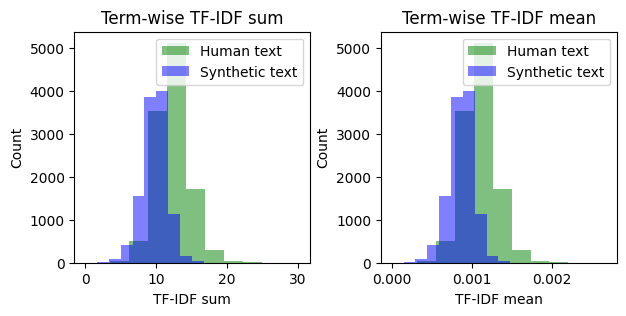

In [5]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (7, 3),
    gridspec_kw = {'wspace':0.3, 'hspace':0.5}
)

axs[0].set_title('Term-wise TF-IDF sum')
axs[0].hist(human_tfidf_df_sum, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0].hist(synthetic_tfidf_df_sum, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0].set_xlabel('TF-IDF sum')
axs[0].set_ylabel('Count')
axs[0].legend(loc = 'upper right')

axs[1].set_title('Term-wise TF-IDF mean')
axs[1].hist(human_tfidf_df_mean, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1].hist(synthetic_tfidf_df_mean, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1].set_xlabel('TF-IDF mean')
axs[1].set_ylabel('Count')
axs[1].legend(loc = 'upper right')

plt.show()

OK, cool - this actualy looks really good - the distributions are clearly different. Problem is, we can't calculate these seperatly for an unknown fragment. Let's do corpus wide TF-IDF and then use the term-wise TF-IDF values to score the text fragments and see if the distributions are still different.

In [6]:
# Get lists of human and synthetic text and combine
human_texts=list(data_df['Human text'])
synthetic_texts=list(data_df['Synthetic text'])

texts = human_texts + synthetic_texts

In [7]:
# Set-up sklearn TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(input = 'content')

# Get TFIDF values and convert to dataframe
tfidf_vector = tfidf_vectorizer.fit_transform(texts)

tfidf_df = pd.DataFrame(
    tfidf_vector.toarray(),
    columns = tfidf_vectorizer.get_feature_names_out()
)

In [8]:
# Get corpus wide mean by word
tfidf_df_sum = tfidf_df.sum(axis = 1)
tfidf_df_mean = tfidf_df_sum / len(tfidf_df_sum)

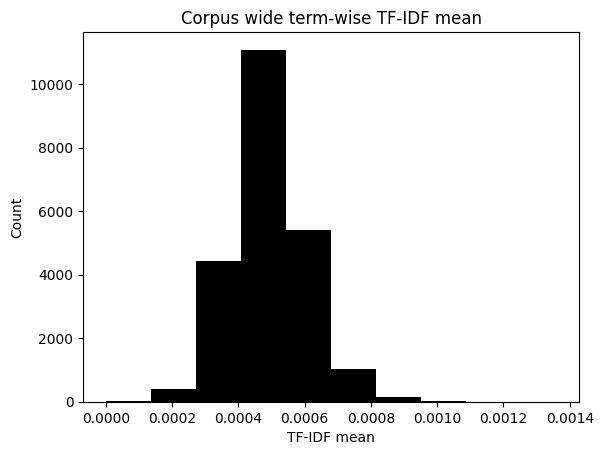

In [9]:
plt.title('Corpus wide term-wise TF-IDF mean')
plt.hist(tfidf_df_mean, color = 'black')
plt.xlabel('TF-IDF mean')
plt.ylabel('Count')

plt.show()

OK, now make a dictionary to use as a look-up table whith the word as the key and the TF-IDF mean as the value.

In [10]:
tfidf_lut = dict(zip(tfidf_df.columns, tfidf_df_mean))

Now score the text fragments from the training data. Think we have to do this with a loop.

In [12]:
# Load the data
data_df = pd.read_json(config.COMBINED_SCORED_HANS_DATA_KL)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75250 entries, 0 to 75249
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (tokens)  75250 non-null  int64  
 1   Dataset                   75250 non-null  object 
 2   Source                    75250 non-null  object 
 3   String                    75250 non-null  object 
 4   Perplexity                75250 non-null  float64
 5   Cross-perplexity          75250 non-null  float64
 6   Perplexity ratio score    75250 non-null  float64
 7   Kullback-Leibler score    75198 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 5.2+ MB


In [17]:
# Holders for TF-IDF values
human_fragment_tfidf_sums = []
synthetic_fragment_tfidf_sums = []

# Set-up sklearn TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(input = 'content')

# Loop on dataframe rows
for index, row in data_df.iterrows():
    
    tfidf_sum = 0

    try:

        # Get tfidf vector
        tfidf_vector = tfidf_vectorizer.fit_transform([row['String']])
        feature_names = tfidf_vectorizer.get_feature_names_out()

        for feature_name in feature_names:
            if feature_name in tfidf_lut.keys():
                tfidf_sum += tfidf_lut[feature_name]

        if row['Source'] == 'Human':
            human_fragment_tfidf_sums.append(tfidf_sum)

        elif row['Source'] == 'Synthetic':
            synthetic_fragment_tfidf_sums.append(tfidf_sum)

    except ValueError as e:
        print(e)



empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

In [18]:
len(synthetic_fragment_tfidf_sums)

0

Ok - so, not working. Need to learn a bit more about what is in the vectorizer's vocabulary. Also have a concern about data leakage here - we should probably save some data for true out-of-sample test/validation. Not sure the best way to do that, since the text fragments are sampled from the records in the Hans 2024 corpus, but we can probably figure something out. 